# Deeptime Notebook (DMAT)

A combination of the PyEMMA and Deeptime tutorials. Attempting to do everything within deeptime.

For CA-CTD D1D2 standard simulation data.

In [1]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import deeptime
import pickle
import wedap
from tqdm.auto import tqdm

# Require deeptime, ipywidgets, tqdm. numpy and matplotlib

/home/dty7/Apps/anaconda3/envs/msm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Common variables across all checkpoints
n_clusters = [5, 10, 30, 75, 200, 450]
lagtimes = [1, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 10000]

In [3]:
model_name = "2024-05-27_D1D2_13k_dmat"

In [4]:
import os
if not os.path.exists(model_name):
    os.mkdir(model_name)

### Load features

Load data directly from the west.h5 file:

In [10]:
dap = wedap.H5_Pdist("west-13k-dmat.h5", data_type="average")

Testing out how to transform 75x75 dmat into 1d feature array:

In [17]:
dmat1 = dap.h5["iterations/iter_00000001/auxdata/inter_ca_dmat"][:]

In [25]:
dmat1[0].shape

(75, 75)

In [26]:
# Using the upper triangular part excluding the diagonal to avoid redundancy
# testing for the first segment only (0)
upper_triangle = dmat1[0][np.triu_indices(dmat1[0].shape[0], k=1)]

In [27]:
upper_triangle

array([37.985, 36.98 , 35.353, ..., 42.603, 40.096, 38.029])

In [28]:
upper_triangle.shape

(2775,)

In [31]:
# set n_features for dmat, before this would be determined by tau n_frames
# but here we are instead using 1 frame and including alot of features, before only 1 feature and many frames
#dmat_feat_len = upper_triangle.shape[0]

Need to ensure data is correctly formatted with end to end of each 1$\mu$s traj

In [56]:
test_dmat = dap.h5[f"iterations/iter_{1:08d}/auxdata/inter_ca_dmat"][0]

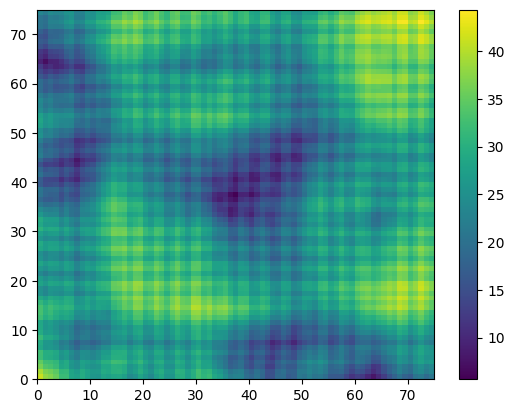

In [61]:
plt.pcolormesh(test_dmat)
plt.colorbar()

Originally, I thought it would be useful to take the upper triangle since e.g. a CA-CA inter dmat would be symmetric about the diagonal, but I'm using a inter monomer dmat, so as you can see on the plot, it's not completely symmetric. Meaning I need to use the entire dmat.

In [58]:
test_dmat.flatten().shape

(5625,)

In [59]:
dmat_feat_len = dap.h5[f"iterations/iter_{1:08d}/auxdata/inter_ca_dmat"][0].flatten().shape[0]

In [60]:
dmat_feat_len

5625

In [62]:
def get_full_coords(walker_tuple, data_name, data_index=0, first_iter=1):
    """
    Returns a full 1D set of data for a single trace (path).
    This will be ordered from the first iter to the last.

    Parameters
    ----------
    walker_tuple : tuple
        (iteration, walker) start point to trace from.
    data_name : str
        Name of dataset.
    data_index : int
        Index of dataset.
    first_iter : int
        Iter to trace back to. Default 1.
        
    Returns
    -------
    coordinates : 1d array
        Array of coordinates from the list of (iteration, walker) tuples.
    """
    # account for non-pcoord input strings
    if data_name != "pcoord":
        data_name = "auxdata/" + data_name

    path = dap.trace_walker(walker_tuple, first_iter)
    # Initialize an array for the pcoords (rows: n_iters, cols: dmat_feat_len)
    coords = np.zeros((len(path),dmat_feat_len))
    
    # Loop over the path and get the pcoords for each walker
    # path will be ordered from the first iter to the last.
    for idx, (it, wlk) in enumerate(path):
        # convert 75x75 dmat to 1d feature array
        dmat_flat = dap.h5[f"iterations/iter_{it:08d}/{data_name}"][wlk].flatten()
        
        # fill out the array
        coords[idx,:] = dmat_flat

    return coords 

In [63]:
# Can try with only last percentage of data (e.g. 300ns +) 
# Need to prob cut tau, no just need to put a first iter
def get_data_array_ordered(data_name, save_name=None, first_iter=1):
    """
    Parameters
    ----------
    data_name : str
        Name of the dataset in the west.h5 file.
    save_name : str
        Name to save data as (ext .npy), default None, which uses
        data_name.npy. Otherwise will use save_name.npy.
    first_iter : int
        First iter of the h5 file to use.
    """
    # number of states
    n_bstates = len(dap.h5["ibstates/0/bstate_index"])

    if save_name is None:
        save_file_path = data_name
    else:
        save_file_path = save_name
    
    # set n_iters
    n_iters = dap.last_iter - (first_iter - 1)
    
    # pre-cast array for dataset: rows = n_bstates * n_iters, cols = dmat_feat_len
    data_array = np.zeros((n_bstates*n_iters, dmat_feat_len))
    
    # loop each of the 68 long trajectories
    for bs in tqdm(range(n_bstates)):
        # fill out each section of the array based on each full traj of each state
        data_array[bs*n_iters:(bs+1)*n_iters,:] = get_full_coords((dap.last_iter,bs), data_name, first_iter=first_iter)

    np.save(f"{save_file_path}.npy", data_array)
    return data_array

In [ ]:
get_data_array_ordered(data_name="inter_ca_dmat", save_name="dmat")

 75%|███████████████████████████████████████████▌              | 51/68 [3:47:31<2:19:01, 490.67s/it]

Load the inter CA distance matrix as a set of features per frame (each frame is an iteration (100 ps $\tau$))

In [ ]:
dmat = np.load("dmat.npy")

### Previous Curated Feats

In [4]:
# load input feature data 30p
oa1 = np.load("oa1_30p.npy")
oa2 = np.load("oa2_30p.npy")
tt = np.load("tt_30p.npy")
m1x1 = np.load("m1x1_30p.npy")
m2x1 = np.load("m2x1_30p.npy")
c2 = np.load("c2_30p.npy")

In [5]:
oa1.shape

(5236748,)

Need to proc the torsion data to account for periodic conditions, function from my ndpredict code.

In [6]:
def proc_angle_data(data):
    """
    Periodic angles (e.g. dihedrals) near periodic boundaries will
    behave poorly since -179° and 179° are actually only 2° away.
    This converts an angle array from degrees to radians, then returns 
    the sin and cos of the radians.

    Parameters
    ----------
    data : array
        1D array of angle values in degrees.

    Returns
    -------
    data_rad_cos_sin : array
        Array of shape (data, 2). For each angle input value, returns the 
        cos and sin output to remove periodicity effects.
    """
    # conver to rads
    data_rad = data * np.pi / 180
    # convert to cos and sin
    data_rad_cos = np.cos(data_rad)
    data_rad_sin = np.sin(data_rad)
    # stack sin and cos arrays:
    data_rad_cos_sin = np.column_stack((data_rad_cos, data_rad_sin))
    return data_rad_cos_sin

In [7]:
m1x1_proc = proc_angle_data(m1x1)
m1x1_proc.shape

(5236748, 2)

In [8]:
m2x1_proc = proc_angle_data(m2x1)
m2x1_proc.shape

(5236748, 2)

In [9]:
# column stack
features = np.column_stack((oa1,oa2,tt,m1x1_proc,m2x1_proc,c2))
features.shape

(5236748, 8)

In [37]:
features.shape[0]*0.3

2244000.0

In [76]:
# reduce dataset size by 10x for testing
features = features[::10,:]
features.shape

TODO: could test adding additional features (chi1 and c2), also need to perform a cos/sin transformation of the torsions before TICA in order to preserve their periodicity.

Could also featurize/dim-reduce using input as xyz coords, inter-monomer distance matrices, or feed these to vampNets.

### Standardize features before clustering or dim red

In [383]:
#from sklearn.preprocessing import StandardScaler
## scale data
#scaler = StandardScaler()
#features = scaler.fit_transform(features)

In [520]:
from sklearn.preprocessing import MinMaxScaler
# scale data
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

In [607]:
#from sklearn.preprocessing import normalize
#features = normalize(features, norm='l2')


### TODO: test how good features are using VAMP-2 score, might be useful to test different scaling and norm

In [287]:
from deeptime.decomposition import VAMP

model = VAMP(lagtime=1, dim=1).fit(features).fetch_model()
#deeptime.decomposition.vamp_score(msms[0], 'vamp2')

In [288]:
model.score(r=2)

1.9961133589353879

### Test using tICA or VAMP dim red before clustering

In [ ]:
from deeptime.decomposition import TICA

tica = TICA(lagtime=1)

In [ ]:
data = np.random.uniform(size=(1000, 5))
tica.fit(data)

In [ ]:
covariances = TICA.covariance_estimator(lagtime=1) \
    .fit(data)
tica.fit(covariances)

In [ ]:
model = tica.fetch_model()
projection = model.transform(np.random.uniform(size=(500, 5)))
print(projection.shape)

### Clustering init

In [608]:
# Run K-means on multiple cluster numbers
clusters = []
dtrajs = []
for n in n_clusters:
    cluster = deeptime.clustering.KMeans(n_clusters=n, max_iter=500, progress=tqdm)
    dtraj = cluster.fit_transform(features)
    dtrajs.append(dtraj)
    clusters.append(cluster.fetch_model())

KMeans iterations: 100%|███████████████████████████████████████████████| 181/181 [11:51<00:00,  3.93s/it]


## Checkpoint 1/4

In [278]:
# Read previous data
with open(f'{model_name}_clusters.pickle','rb') as file:
    clusters = pickle.load(file)
with open(f'{model_name}_dtrajs.pickle','rb') as file:
    dtrajs = pickle.load(file)

In [609]:
# Write previous data
with open(f'{model_name}_clusters.pickle','wb') as file:
    pickle.dump(clusters, file)
with open(f'{model_name}_dtrajs.pickle','wb') as file:
    pickle.dump(dtrajs, file)

In [610]:
# Make the count matrix for various lagtimes.
lagtimes = [1, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 10000]
countm = []
for dtraj in dtrajs:
    c_small = []
    for lag in lagtimes:
        estimator = deeptime.markov.TransitionCountEstimator(lag, 'sliding')
        c_small.append(estimator.fit(dtraj).fetch_model())
    countm.append(c_small)

## Checkpoint 2/4

In [302]:
# Read previous data
with open(f'{model_name}_countm.pickle','rb') as file:
    countm = pickle.load(file)

In [611]:
# Write previous data
with open(f'{model_name}_countm.pickle','wb') as file:
    pickle.dump(countm, file)

In [612]:
# Make MSM for each cluster/lagtime
estimator = deeptime.markov.msm.MaximumLikelihoodMSM(reversible=True, stationary_distribution_constraint=None)
msms = []
for matrix in countm:
    small = []
    for m, lag in zip(matrix, lagtimes):
        small.append(estimator.fit(m, lagtime=lag).fetch_model())
    msms.append(small)

### To optimize n_clusters: calc VAMP-2 score as a function of cluster centers

In [326]:
dtrajs

[array([1, 1, 1, ..., 2, 2, 2], dtype=int32),
 array([1, 1, 9, ..., 2, 2, 2], dtype=int32),
 array([11, 11,  1, ..., 21, 19, 21], dtype=int32),
 array([34, 34, 16, ..., 43, 52, 54], dtype=int32),
 array([154,  88, 154, ..., 190, 108, 190], dtype=int32),
 array([221,  82,  26, ..., 283, 136, 283], dtype=int32)]

In [328]:
n_clusters

[5, 10, 30, 75, 200, 450]

In [ ]:
# Run K-means on multiple cluster numbers
clusters = []
dtrajs = []
for n in [100, 300, 800, 1500, 3000]:
    cluster = deeptime.clustering.KMeans(n_clusters=n, max_iter=500, progress=tqdm)
    dtraj = cluster.fit_transform(features)
    dtrajs.append(dtraj)
    clusters.append(cluster.fetch_model())

KMeans++ initialization:  43%|██████████████▍                   | 1276/3000 [04:41<06:30,  4.41it/s]

In [ ]:
# Making MSM for each cluster at set lagtime
lag = 5

# first make count matrices at each clustering amount
clust_countm = []
tc_estimator = deeptime.markov.TransitionCountEstimator(lag, 'sliding')
for dtraj in dtrajs:
    clust_countm.append(tc_estimator.fit(dtraj).fetch_model())

# Make MSM for each cluster at set lagtime
clust_msms = []
msm_estimator = deeptime.markov.msm.MaximumLikelihoodMSM(reversible=True, stationary_distribution_constraint=None)
for matrix in clust_countm:
    clust_msms.append(msm_estimator.fit(matrix, lagtime=lag).fetch_model())

In [ ]:
msms[0][0].score(r=2)

In [ ]:
len(clust_countm)

In [ ]:
len(clust_msms)

Now the models are scored, which evaluates how much “slowness” is captured with the current input features. 

Note that scores can not be compared across different lagtimes $\tau$.

In [ ]:
scores = []
for msm in clust_msms:
    scores.append(msm.score(r=2))

In [ ]:
plt.plot(scores)

## Checkpoint 3/4

In [289]:
# Read previous data
with open(f'{model_name}_msms.pickle','rb') as file:
    msms = pickle.load(file)

In [613]:
# Write previous data
with open(f'{model_name}_msms.pickle','wb') as file:
    pickle.dump(msms, file)

/home/dty7/Apps/anaconda3/envs/msm/lib/python3.10/site-packages/deeptime/markov/tools/analysis/_api.py:256: UserWarning: truncated eigendecomposition to contain 5 components
  warnings.warn('truncated eigendecomposition to contain %s components' % new_k, category=UserWarning)


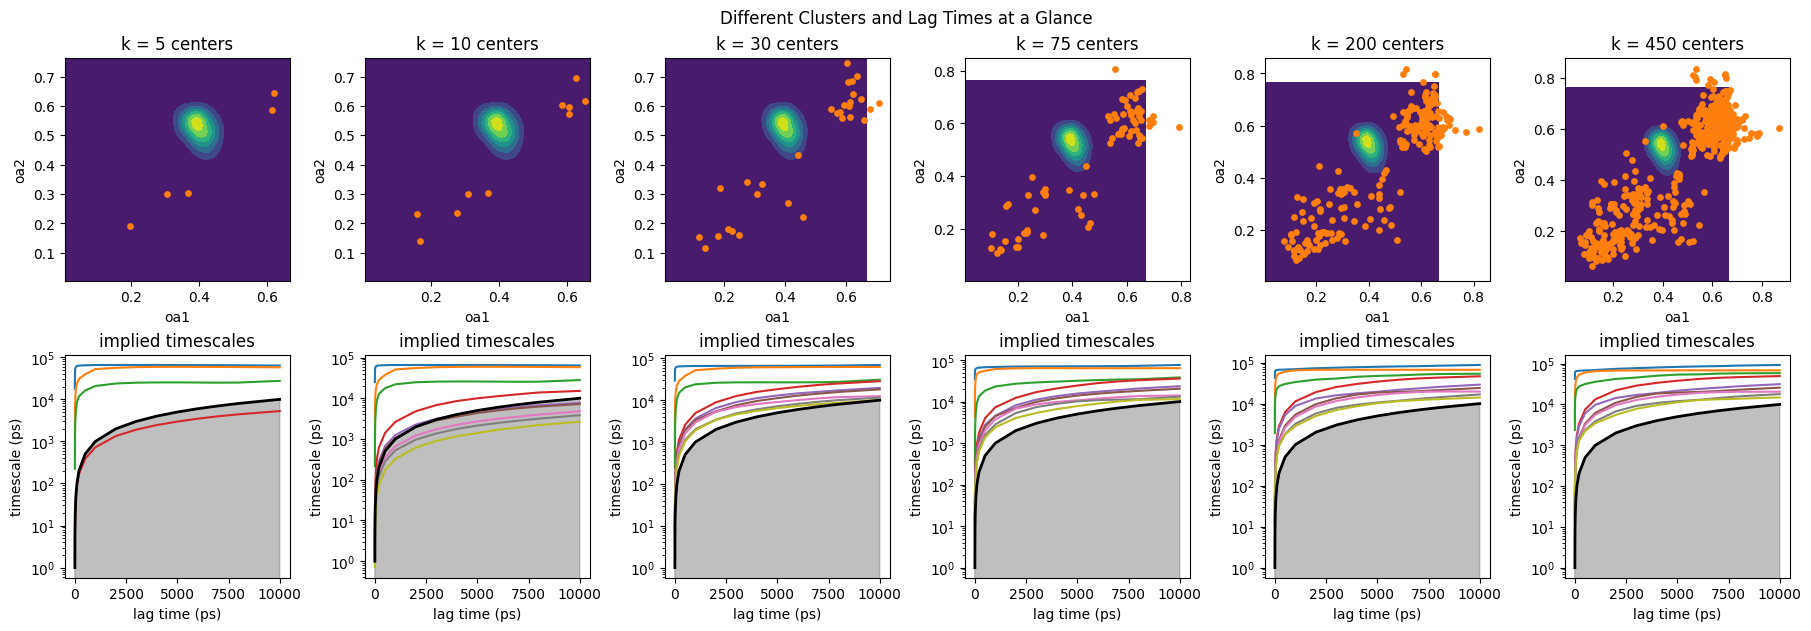

In [637]:
# Try and plot the many different cluster centers

# Setting up the figure/Axes objects...
fig = plt.figure(constrained_layout=True, figsize=(18,6.2))
gs = fig.add_gridspec(2, len(n_clusters))
axes = []
for idx in range(2):
    axes.append([])
    for jdx in range(len(n_clusters)):
        axes[idx].append(fig.add_subplot(gs[idx, jdx]))
axes = np.asarray(axes)
# This is a simplified way to setup but might create overlap
#fig, axes = plt.subplots(2, len(n_clusters), figsize=(18, 6.2))

# Plotting things...
for i, (n, cluster, dtraj, msm) in enumerate(zip(n_clusters, clusters, dtrajs, msms)):
    # Top row...
    deeptime.plots.plot_density(*features[:,:2].T[::-1], ax=axes[0, i]) # Note .T reverses Phi/Psi
    axes[0, i].scatter(*cluster.cluster_centers[:,:2].T, s=15, c='C1')
    axes[0, i].set_xlabel('oa1')
    axes[0, i].set_ylabel('oa2')
    axes[0, i].set_title('k = {} centers'.format(n))
    #axes[0, i].set_xticks([j for j in range(-180,181,60)])
    #axes[0, i].set_xticks([j for j in range(-180,181,60)])
    
    # Bottom row...
    deeptime.plots.plot_implied_timescales(
        deeptime.util.validation.implied_timescales(msm, n_its=9),
        ax=axes[1, i])
    axes[1, i].set_xlabel('lag time (ps)')
    axes[1, i].set_ylabel('timescale (ps)')
    axes[1, i].set_yscale('log')
    axes[1, i].set_title('implied timescales')
    #axes[1, i].set_ylim(1, 2000)

#fig.tight_layout()
fig.suptitle('Different Clusters and Lag Times at a Glance')
fig.savefig(f'{model_name}_its.pdf')

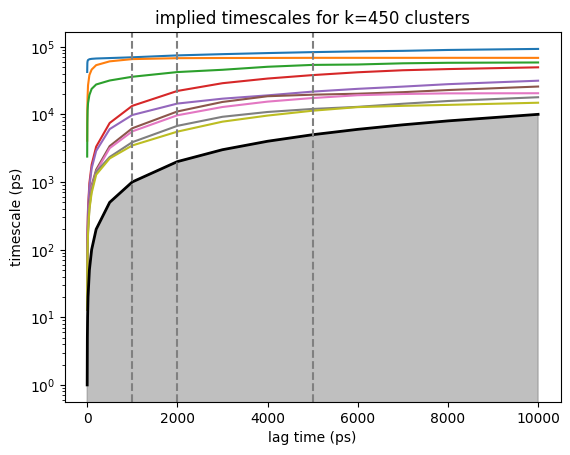

In [69]:
# Blowing one of the implied timescale plot up by replotting it.
index = -1 # Looking at the last one.
plot = deeptime.plots.plot_implied_timescales(
    deeptime.util.validation.implied_timescales(msms[index], n_its=9))
plot.set_xlabel('lag time (ps)');
plot.set_ylabel('timescale (ps)');
plot.set_title(f'implied timescales for k={n_clusters[-1]} clusters');
#plot.set_ylim(0,10);
plot.axvline(1000, linestyle='--', color='grey');
plot.axvline(2000, linestyle='--', color='grey');
plot.axvline(5000, linestyle='--', color='grey');
#plot.legend(lagtimes,loc='upper right');
#plot.legend(loc='upper right');
plot.set_yscale("log")
## Choosing 10ps * 5ps = report every 50 ps
plot.figure.savefig(f'{model_name}_final_its.pdf')

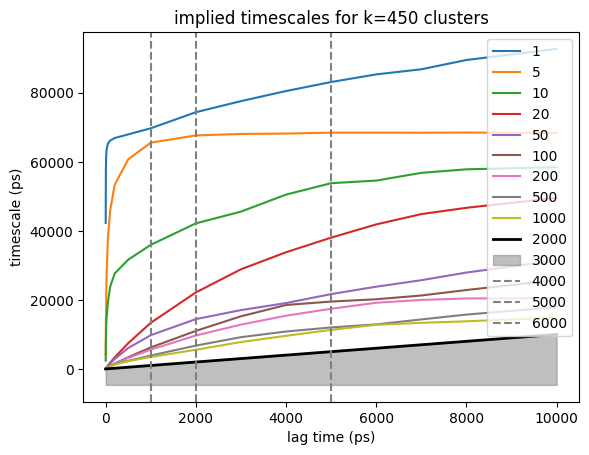

In [639]:
# Blowing one of the implied timescale plot up by replotting it.
index = -1 # Looking at the last one.
plot = deeptime.plots.plot_implied_timescales(
    deeptime.util.validation.implied_timescales(msms[index], n_its=9))
plot.set_xlabel('lag time (ps)');
plot.set_ylabel('timescale (ps)');
plot.set_title(f'implied timescales for k={n_clusters[-1]} clusters');
#plot.set_ylim(0,2000);
plot.axvline(1000, linestyle='--', color='grey');
plot.axvline(2000, linestyle='--', color='grey');
plot.axvline(5000, linestyle='--', color='grey');
#plot.legend(lagtimes,loc='upper right');
plot.figure.savefig(f'{model_name}_final_its_linear.pdf')

In [640]:
final_lag = 5000
index = -1 # Looking at the last one.
final_cluster= clusters[index]
final_dtrajs = dtrajs[index][:]
estimator = deeptime.markov.TransitionCountEstimator(final_lag, 'sliding')
final_count = estimator.fit(final_dtrajs).fetch_model()
estimator = deeptime.markov.msm.MaximumLikelihoodMSM(reversible=True, stationary_distribution_constraint=None)
final_msm = estimator.fit(final_count, lagtime=None).fetch_model()

In [641]:
final_dtrajs.shape

(5236748,)

In [642]:
final_msm.transition_matrix

array([[0.01183476, 0.00010807, 0.        , ..., 0.00107967, 0.        ,
        0.0144824 ],
       [0.0001561 , 0.02692346, 0.        , ..., 0.        , 0.00085631,
        0.00031231],
       [0.        , 0.        , 0.07370184, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00149939, 0.        , 0.        , ..., 0.06703217, 0.        ,
        0.00113789],
       [0.        , 0.00634452, 0.        , ..., 0.        , 0.00671141,
        0.        ],
       [0.0134917 , 0.00020143, 0.        , ..., 0.00076331, 0.        ,
        0.01478038]])

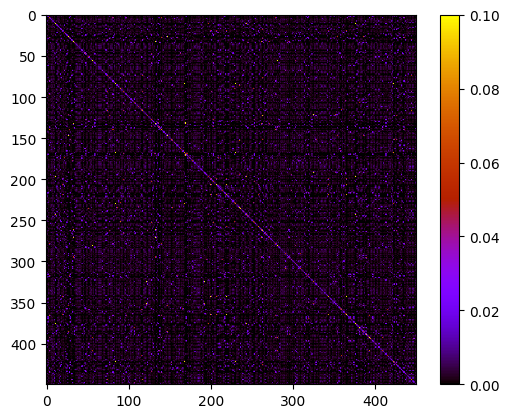

In [643]:
plt.imshow(final_msm.transition_matrix, vmax=0.1, cmap="gnuplot")
plt.colorbar()

In [10]:
# Read previous data
with open(f'{model_name}_final.pickle','rb') as file:
    [final_cluster, final_dtrajs, final_count, final_msm] = pickle.load(file)

In [621]:
# Write previous data
with open(f'{model_name}_final.pickle','wb') as file:
    pickle.dump([final_cluster, final_dtrajs, final_count, final_msm], file)

### TODO: MSM ITS / spectral analysis to further confirm n macrostates

In [77]:
mean_timescales = []
std_timescales = []
for i in range(10):
    ts = deeptime.util.validation.implied_timescales(msms[index], n_its=10).timescales_for_process(i)
    mean_timescales.append(np.mean(ts))
    std_timescales.append(np.std(ts))

<ErrorbarContainer object of 3 artists>

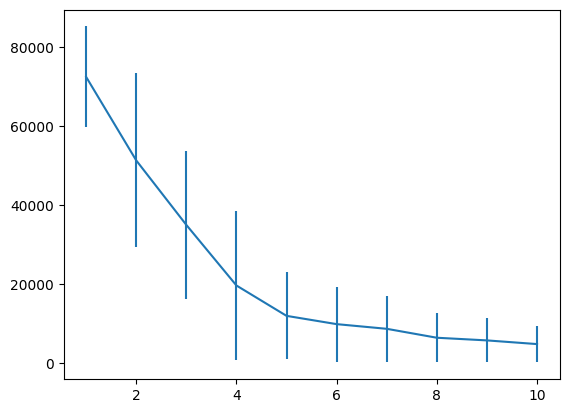

In [79]:
plt.errorbar([i for i in range(1,11)], mean_timescales, yerr=std_timescales)

### CK test for MSM Markovianity with n number of macrostates

In [ ]:
from deeptime.markov.msm import BayesianMSM
from deeptime.plots.chapman_kolmogorov import plot_ck_test

In [370]:
msms

[[MarkovStateModelCollection-140421005477008:[{'count_models': None,
                                              'reversible': True,
                                              'stationary_distributions': None,
                                              'transition_matrices': None,
                                              'transition_matrix_tolerance': 1e-06}],
  MarkovStateModelCollection-140421005919904:[{'count_models': None,
                                              'reversible': True,
                                              'stationary_distributions': None,
                                              'transition_matrices': None,
                                              'transition_matrix_tolerance': 1e-06}],
  MarkovStateModelCollection-140424297240352:[{'count_models': None,
                                              'reversible': True,
                                              'stationary_distributions': None,
                                 

In [379]:
ck_test = final_msm.ck_test(msms[-1], n_metastable_sets=4)

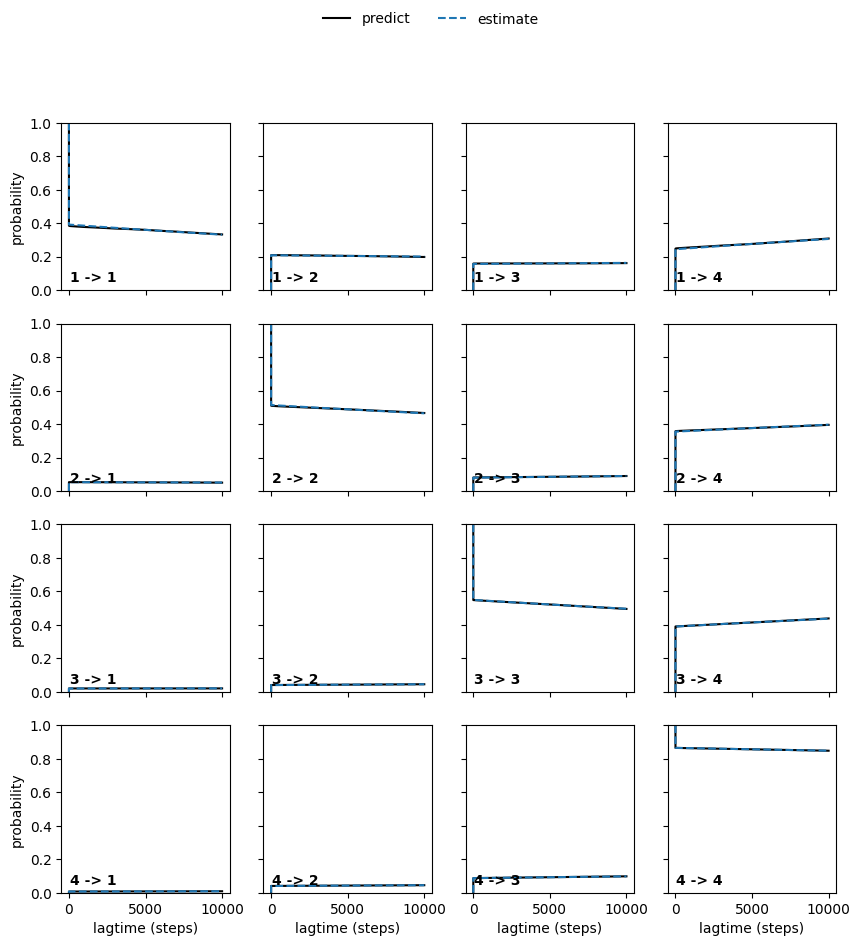

In [380]:
plot_ck_test(ck_test)

With error:

In [ ]:
models = []
lagtimes = [1, 100, 1000, 5000, 7500]
for lag in tqdm(lagtimes):
    counts_estimator = TransitionCountEstimator(lagtime=lag, count_mode='effective')
    models.append(BayesianMSM().fit_fetch(counts_estimator.fit_fetch(final_dtrajs).submodel_largest()))

100%|██████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 80.18it/s]


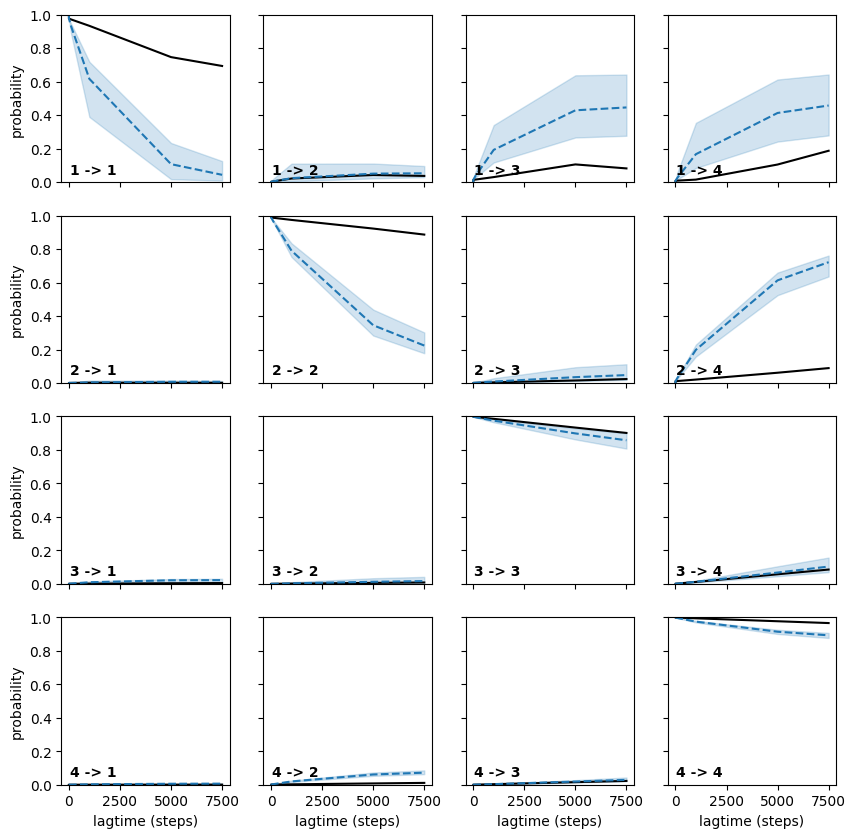

In [386]:
test_model = models[0]
ck_test = test_model.ck_test(models, n_metastable_sets=4, progress=tqdm)
grid = plot_ck_test(ck_test, legend=False)

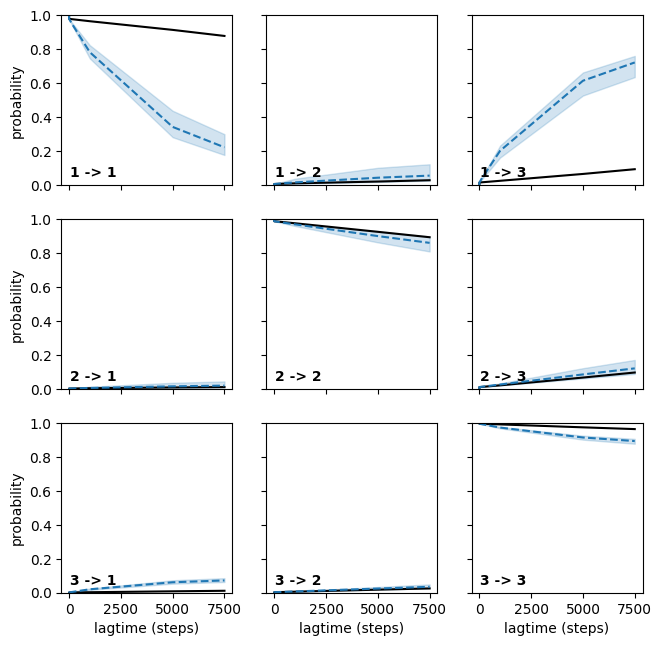

In [383]:
test_model = models[0]
ck_test = test_model.ck_test(models, n_metastable_sets=3, progrss=tqdm)
grid = plot_ck_test(ck_test, legend=False)

100%|█████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 123.54it/s]


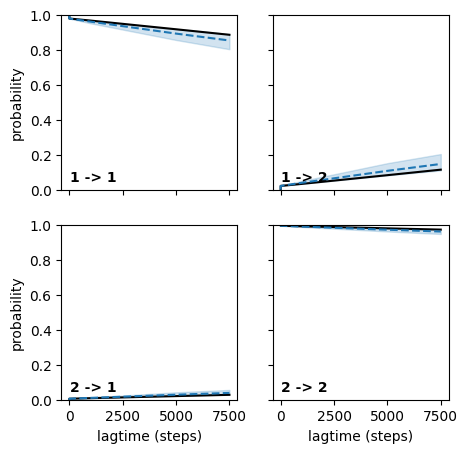

In [385]:
test_model = models[0]
ck_test = test_model.ck_test(models, n_metastable_sets=2, progress=tqdm)
grid = plot_ck_test(ck_test, legend=False)

### Plot stationary dist and reweighted free energy 
(also look at ∆kT of D1 and D2 and compare to W184 N$\epsilon$ HSQC)

In [ ]:
dir(final_msm)

In [11]:
weights = final_msm.compute_trajectory_weights(final_dtrajs)

In [175]:
final_dtrajs.shape

(5236748,)

In [174]:
final_msm.stationary_distribution.shape

(450,)

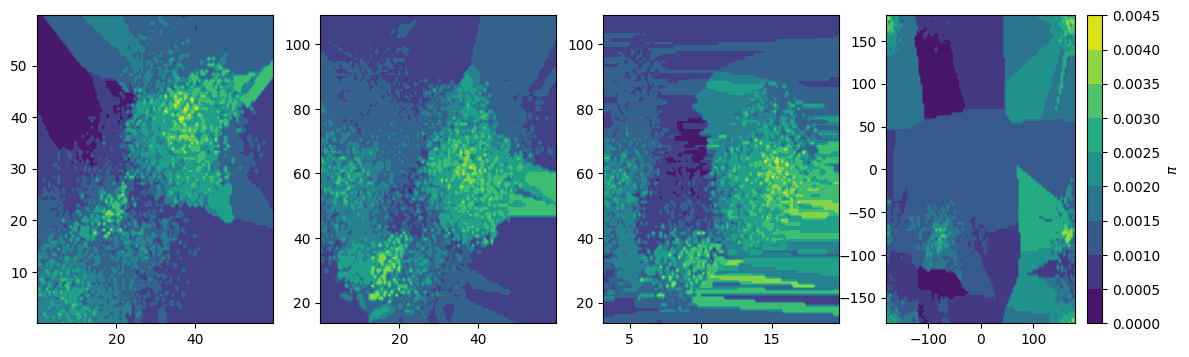

In [177]:
fig, ax = plt.subplots(ncols=4, figsize=(14, 4))

plot, mapping = deeptime.plots.plot_contour2d_from_xyz(
    oa1, oa2,
    final_msm.stationary_distribution[final_dtrajs], ax=ax[0])
plot, mapping = deeptime.plots.plot_contour2d_from_xyz(
    oa1, c2,
    final_msm.stationary_distribution[final_dtrajs], ax=ax[1])
plot, mapping = deeptime.plots.plot_contour2d_from_xyz(
    tt, c2,
    final_msm.stationary_distribution[final_dtrajs], ax=ax[2])
plot, mapping = deeptime.plots.plot_contour2d_from_xyz(
    m1x1, m2x1,
    final_msm.stationary_distribution[final_dtrajs], ax=ax[3])

cbar = plt.colorbar(mapping)
cbar.set_label('$\pi$')

In [272]:
plot, mapping = deeptime.plots.plot_contour2d_from_xyz(
    oa1, oa2,
    -np.log(final_msm.stationary_distribution[final_dtrajs]), ax=None)
cbar = plt.colorbar(mapping)
cbar.set_label('G/kT')

In [655]:
features.shape

(5236748, 8)

In [656]:
weights[0].shape

(5236748,)

In [169]:
fig, ax = plt.subplots(ncols=3, figsize=(14,3))

f1 = oa1
f2 = c2
energies = deeptime.util.energy2d(f1, f2, weights=weights[0])
energies_og = deeptime.util.energy2d(f1, f2)
energies_diff = energies.energies - energies_og.energies
plot = ax[0].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies_og.energies)
cbar = plt.colorbar(plot)
ax[0].set_title("Original")
plot = ax[1].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies.energies)
cbar = plt.colorbar(plot)
ax[1].set_title("Reweighted")
plot = ax[2].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies_diff, vmin=-0.5, vmax=0.5, cmap='bwr')
cbar = plt.colorbar(plot)
ax[2].set_title("Difference")
cbar.set_label('$\Delta$energies/kT')

In [168]:
fig, ax = plt.subplots(ncols=3, figsize=(14,3))

f1 = oa2
f2 = c2
energies = deeptime.util.energy2d(f1, f2, weights=weights[0])
energies_og = deeptime.util.energy2d(f1, f2)
energies_diff = energies.energies - energies_og.energies
plot = ax[0].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies_og.energies)
cbar = plt.colorbar(plot)
ax[0].set_title("Original")
plot = ax[1].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies.energies)
cbar = plt.colorbar(plot)
ax[1].set_title("Reweighted")
plot = ax[2].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies_diff, vmin=-0.5, vmax=0.5, cmap='bwr')
cbar = plt.colorbar(plot)
ax[2].set_title("Difference")
cbar.set_label('$\Delta$energies/kT')

In [167]:
fig, ax = plt.subplots(ncols=3, figsize=(14,3))

f1 = oa1
f2 = oa2
energies = deeptime.util.energy2d(f1, f2, weights=weights[0])
energies_og = deeptime.util.energy2d(f1, f2)
energies_diff = energies.energies - energies_og.energies
plot = ax[0].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies_og.energies)
cbar = plt.colorbar(plot)
ax[0].set_title("Original")
plot = ax[1].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies.energies)
cbar = plt.colorbar(plot)
ax[1].set_title("Reweighted")
plot = ax[2].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies_diff, vmin=-0.5, vmax=0.5, cmap='bwr')
cbar = plt.colorbar(plot)
ax[2].set_title("Difference")
cbar.set_label('$\Delta$energies/kT')

In [166]:
fig, ax = plt.subplots(ncols=3, figsize=(14,3))

f1 = tt
f2 = c2
energies = deeptime.util.energy2d(f1, f2, weights=weights[0])
energies_og = deeptime.util.energy2d(f1, f2)
energies_diff = energies.energies - energies_og.energies
plot = ax[0].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies_og.energies)
cbar = plt.colorbar(plot)
ax[0].set_title("Original")
plot = ax[1].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies.energies)
cbar = plt.colorbar(plot)
ax[1].set_title("Reweighted")
plot = ax[2].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies_diff, vmin=-0.5, vmax=0.5, cmap='bwr')
cbar = plt.colorbar(plot)
ax[2].set_title("Difference")
cbar.set_label('$\Delta$energies/kT')

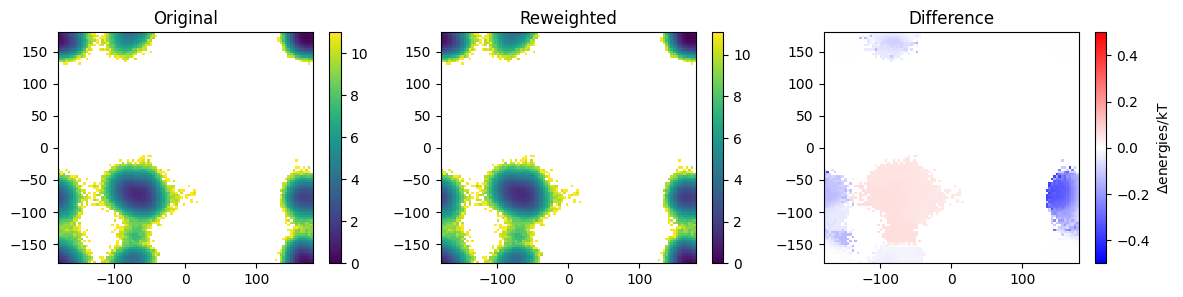

In [165]:
fig, ax = plt.subplots(ncols=3, figsize=(14,3))

f1 = m1x1
f2 = m2x1
energies = deeptime.util.energy2d(f1, f2, weights=weights[0])
energies_og = deeptime.util.energy2d(f1, f2)
energies_diff = energies.energies - energies_og.energies
plot = ax[0].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies_og.energies)
cbar = plt.colorbar(plot)
ax[0].set_title("Original")
plot = ax[1].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies.energies)
cbar = plt.colorbar(plot)
ax[1].set_title("Reweighted")
plot = ax[2].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies_diff, vmin=-0.5, vmax=0.5, cmap='bwr')
cbar = plt.colorbar(plot)
ax[2].set_title("Difference")
cbar.set_label('$\Delta$energies/kT')

In [408]:
energies.x_meshgrid.shape

(100,)

In [561]:
# Find the index of the value closest to the input value
oa = 0.14
xidx = np.argmin(np.abs(energies.x_meshgrid - oa))
yidx = np.argmin(np.abs(energies.y_meshgrid - oa))
xidx,yidx

(13, 13)

In [562]:
d2_energy = energies.energies[xidx,yidx]
d2_energy

1.3163342530629931

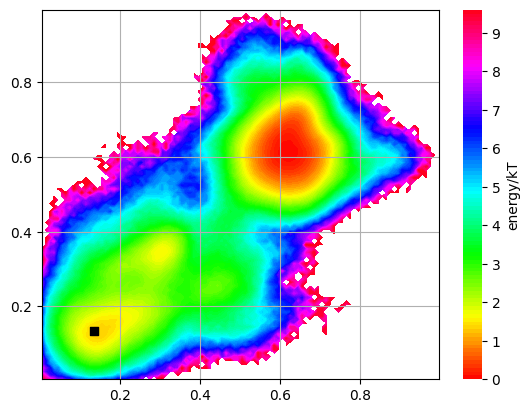

In [563]:
plot = deeptime.plots.plot_energy2d(energies, contourf_kws={'cmap':'hsv'})
plot.colorbar.set_label('energy/kT')
plt.grid()
plt.scatter(energies.x_meshgrid[xidx], energies.y_meshgrid[yidx], marker='s', color='k')
#dir(plot)

In [420]:
# Find the index of the value closest to the input value
oa = 0.65
xidx = np.argmin(np.abs(energies.x_meshgrid - oa))
yidx = np.argmin(np.abs(energies.y_meshgrid - oa))
xidx,yidx

(62, 62)

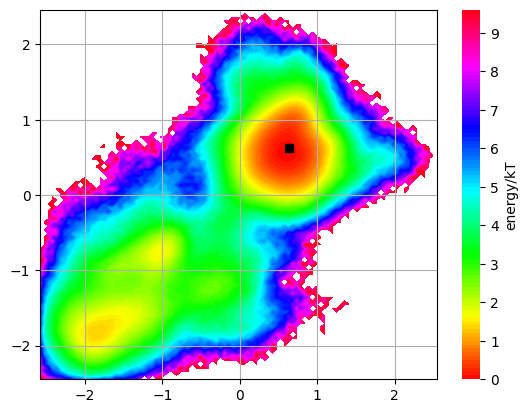

In [421]:
plot = deeptime.plots.plot_energy2d(energies, contourf_kws={'cmap':'hsv'})
plot.colorbar.set_label('energy/kT')
plt.grid()
plt.scatter(energies.x_meshgrid[xidx], energies.y_meshgrid[yidx], marker='s', color='k')
#dir(plot)

In [425]:
d1_energy = energies.energies[xidx,yidx]
d1_energy

0.007869708861213631

### Run PCCA++, plot each fuzzy clusters and course grained tmatrix

And convert dist into crisp assignments

In [40]:
import networkx as nx

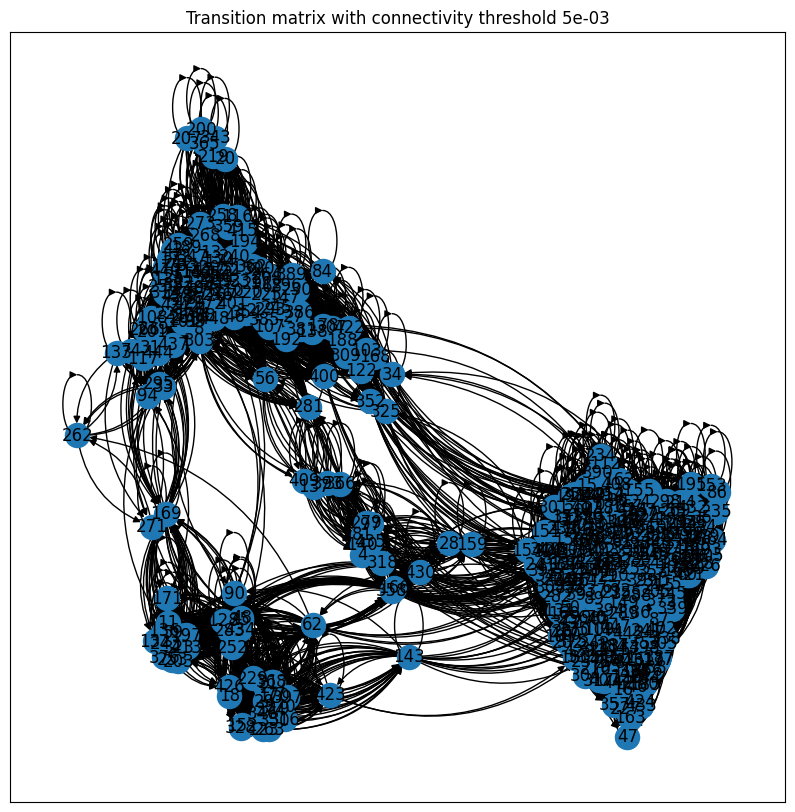

In [669]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

threshold = 5e-3
title = f"Transition matrix with connectivity threshold {threshold:.0e}"
G = nx.DiGraph()
ax.set_title(title)
for i in range(final_msm.n_states):
    G.add_node(i, title=f"{i}")
for i in range(final_msm.n_states):
    for j in range(final_msm.n_states):
        if final_msm.transition_matrix[i, j] > threshold:
            G.add_edge(i, j, title=f"{final_msm.transition_matrix[i, j]:.3e}")

edge_labels = nx.get_edge_attributes(G, 'title')
pos = nx.fruchterman_reingold_layout(G)
nx.draw_networkx_nodes(G, pos, ax=ax)
nx.draw_networkx_labels(G, pos, ax=ax, labels=nx.get_node_attributes(G, 'title'));
nx.draw_networkx_edges(G, pos, ax=ax, arrowstyle='-|>',
                       connectionstyle='arc3, rad=0.3');

In [670]:
final_cluster.cluster_centers[262]

array([0.4643723 , 0.41720849, 0.32826631, 0.01454753, 0.43751187,
       0.5395208 , 0.00388095, 0.35188896])

At middles:

In [376]:
final_cluster.cluster_centers[23]

array([23.37557083, 25.82636917,  5.11485294,  0.60124161, -0.78555536,
        0.48680859, -0.84995577, 67.84506002])

In [377]:
final_cluster.cluster_centers[297]

array([16.93551792, 27.15597306,  6.02493275,  0.15173443, -0.74077643,
        0.3925941 , -0.87925677, 49.67166718])

In [382]:
final_cluster.cluster_centers[390]

array([25.90823991, 34.34505464, 13.14053674, -0.96854106,  0.16128515,
       -0.8435453 , -0.23611221, 55.62834574])

Right cluster:

In [378]:
final_cluster.cluster_centers[173]

array([40.6996802 , 39.59190479, 14.64989392, -0.97718632,  0.11516868,
       -0.9782016 ,  0.10895746, 57.71769408])

Lower left cluster:

In [379]:
final_cluster.cluster_centers[42]

array([ 2.05375482e+01,  1.58237452e+01,  8.27788844e+00, -9.35366191e-01,
        2.54776622e-02,  1.51440869e-01, -9.35579582e-01,  3.26436901e+01])

Upper left cluster:

In [380]:
final_cluster.cluster_centers[283]

array([11.42767837, 17.08674332,  5.31932352,  0.33568974, -0.92209292,
        0.15121698, -0.75338538, 56.40662021])

In [381]:
final_cluster.cluster_centers[224]

array([11.23447257, 16.35939833,  5.34635915,  0.35108069, -0.90253196,
        0.40419305, -0.88536617, 79.91734316])

### PCCA++

In [80]:
# 3 states seems to work well
pcca = final_msm.pcca(n_metastable_sets=4)

In [81]:
pcca.coarse_grained_stationary_probability

array([0.02095986, 0.08315948, 0.16361157, 0.73226909])

In [82]:
pcca.coarse_grained_transition_matrix

array([[0.91476335, 0.0144874 , 0.02074152, 0.05000773],
       [0.0055625 , 0.94492546, 0.00901463, 0.04049741],
       [0.00265945, 0.00489581, 0.94041305, 0.05203168],
       [0.00121384, 0.00474594, 0.01169614, 0.98234408]])

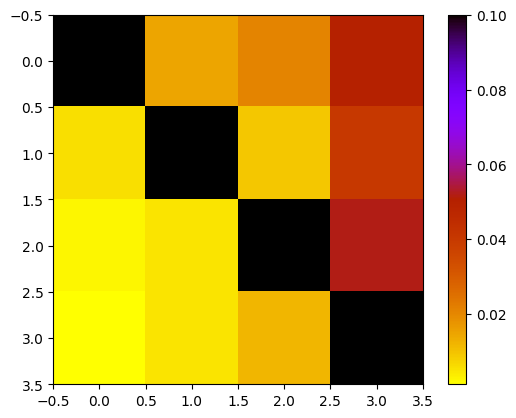

In [83]:
plt.imshow(pcca.coarse_grained_transition_matrix, vmax=0.1, cmap="gnuplot_r")
plt.colorbar()

The membership probabilities can be accessed via pcca.memberships, where each column corresponds to a metastable set defining a probability distribution over the microstates:

In [84]:
print(f"Memberships: {pcca.memberships.shape}")

Memberships: (450, 4)


In [85]:
features.shape

(5236748, 8)

In [86]:
features[:,0]

array([ 8.68659973,  9.0078001 ,  6.40009975, ..., 19.01529884,
       19.53469849, 21.27429962])

In [87]:
def plot_assign_probs(f1,f2):
    fig, axes = plt.subplots(1, pcca.memberships.shape[1], figsize=(15, 6))
    
    for i in range(len(axes)):
        ax = axes[i]
        #ax.set_title(f"Metastable set {i+1} assignment prob")
        ax.set_title(f"State {i} assignment prob")
    
        #ax.scatter(*data.T, c=pcca.memberships[assignments, i], cmap=plt.cm.Blues)
        #ax.hexbin(*features[:,:2].T, C=pcca.memberships[final_dtrajs, i], cmap=plt.cm.Blues)
        #ax.hexbin(*features[:,-2:].T, C=pcca.memberships[final_dtrajs, i], cmap=plt.cm.Blues)
        #ax.hexbin(features[:,2], features[:,-1], C=pcca.memberships[final_dtrajs, i], cmap=plt.cm.Blues)
        ax.hexbin(f1, f2, C=pcca.memberships[final_dtrajs, i], cmap=plt.cm.Blues)
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.Blues), ax=axes, shrink=.8);

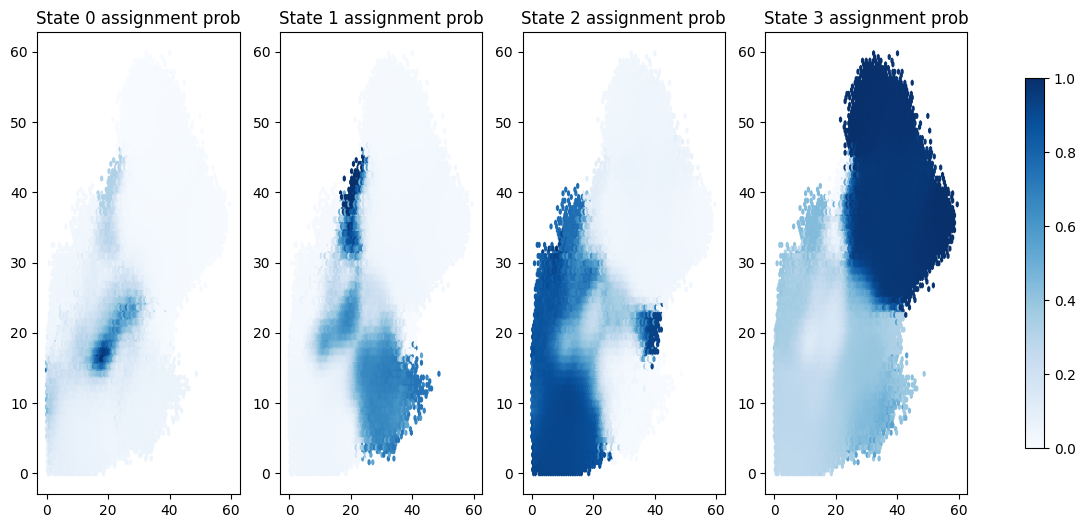

In [88]:
plot_assign_probs(oa1, oa2)

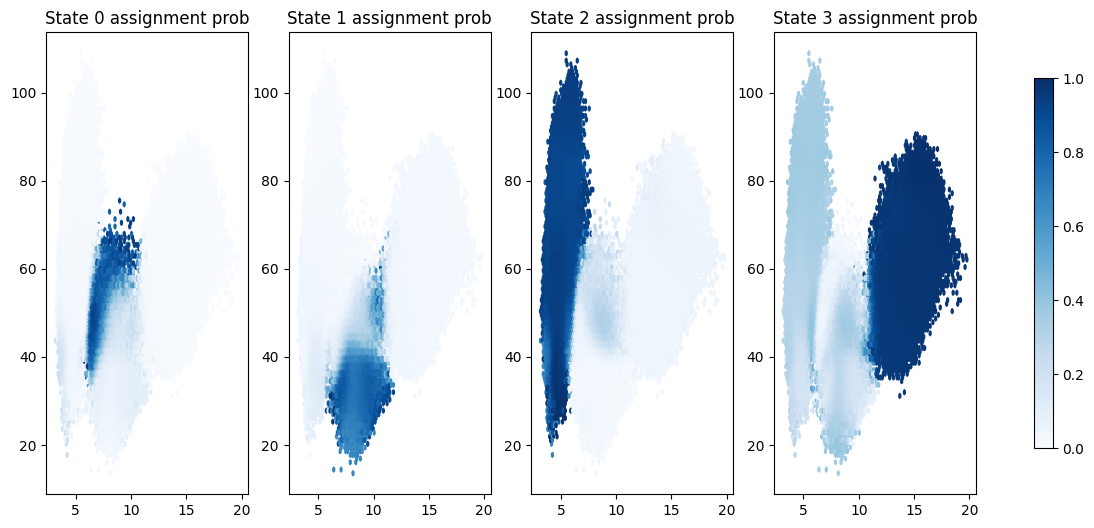

In [89]:
plot_assign_probs(tt, c2)

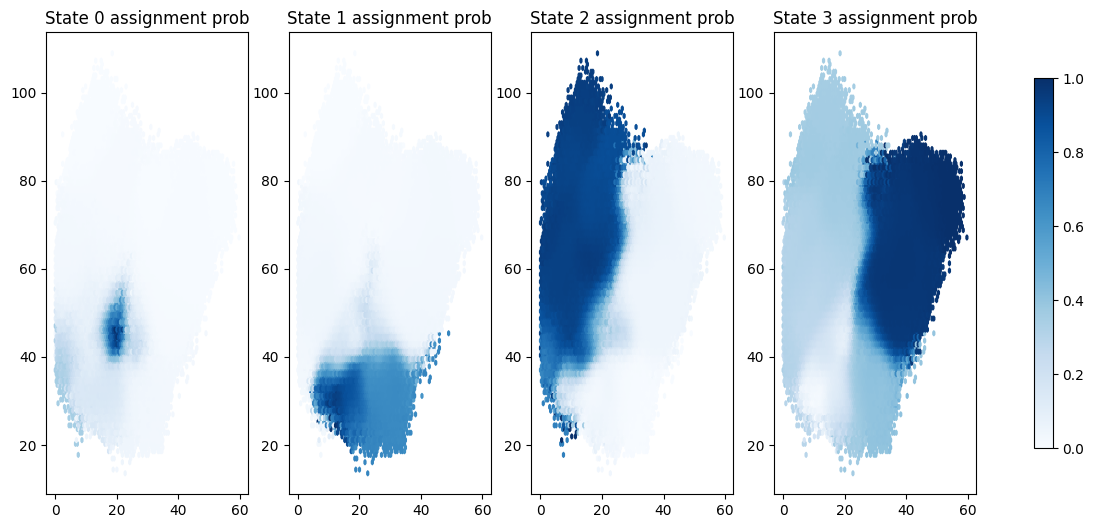

In [90]:
plot_assign_probs(oa1, c2)

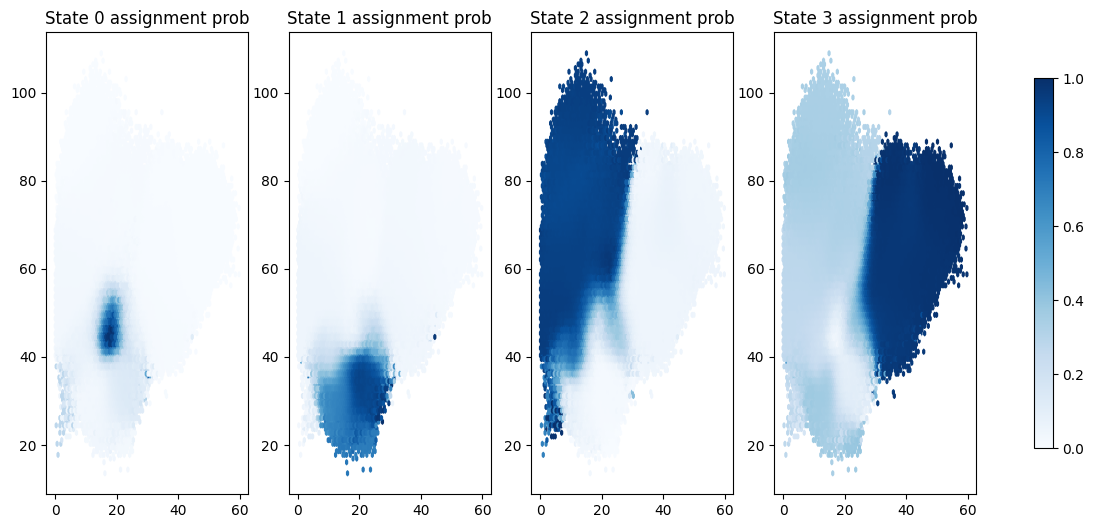

In [112]:
plot_assign_probs(oa2, c2)

Plot on the original chi1 angles:

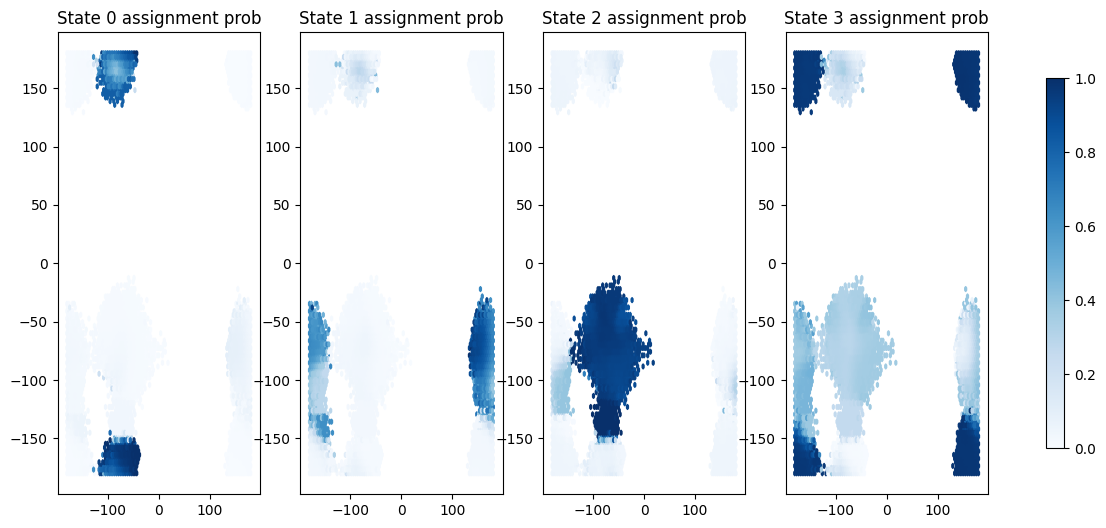

In [91]:
plot_assign_probs(m1x1, m2x1)

For visualization purposes one can obtain the crisp assignments of microstates to macrostates through:

In [92]:
pcca.assignments.shape

(450,)

However caution is appropriate, one cannot compute any actual quantity of the coarse-grained kinetics without employing the fuzzy memberships.

In [263]:
final_msm.transition_matrix_tolerance

1e-06

(<Axes: >,
 {0: array([-1.        , -0.92643025]),
  1: array([-0.90005805,  0.8209041 ]),
  2: array([ 0.9609548 , -0.67405092]),
  3: array([0.93910325, 0.77957707])})

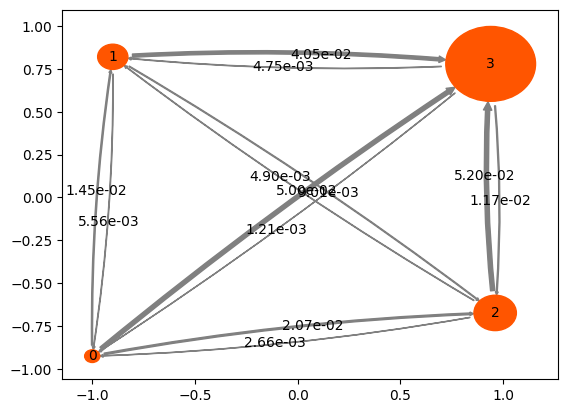

In [93]:
deeptime.plots.plot_markov_model(pcca.coarse_grained_transition_matrix)

### Making full state map

In [209]:
pcca.memberships.shape

(450, 4)

In [224]:
c2.shape

(5236748,)

In [232]:
pcca.assignments[final_dtrajs].shape

(5236748,)

In [236]:
# get color labels
cmap = np.array(["#377eb8", "#ff7f00", "#4daf4a", "#f781bf"])
colors = [cmap[label] for label in pcca.assignments[final_dtrajs]]

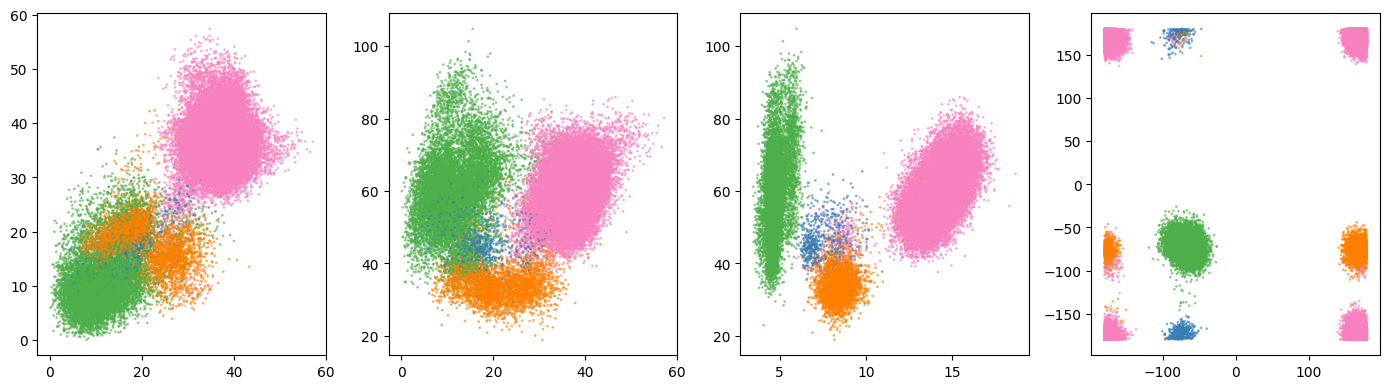

In [254]:
fig, ax = plt.subplots(figsize=(14, 4), ncols=4)
ax[0].scatter(oa1[::100], oa2[::100], c=colors[::100], s=1, alpha=0.5)
ax[1].scatter(oa1[::100], c2[::100], c=colors[::100], s=1, alpha=0.5)
ax[2].scatter(tt[::100], c2[::100], c=colors[::100], s=1, alpha=0.5)
ax[3].scatter(m1x1[::100], m2x1[::100], c=colors[::100], s=1, alpha=0.5)
fig.tight_layout()

In [251]:
fig, ax = plt.subplots(figsize=(14, 4), ncols=4)
plot = ax[0].hexbin(oa1, oa2, pcca.assignments[final_dtrajs], vmin=0)
plot = ax[1].hexbin(oa1, c2, pcca.assignments[final_dtrajs], vmin=0)
plot = ax[2].hexbin(tt, c2, pcca.assignments[final_dtrajs], vmin=0)
plot = ax[3].hexbin(m1x1, m2x1, pcca.assignments[final_dtrajs], vmin=0)
#deeptime.plots.plot_contour2d_from_xyz(oa1, c2, pcca.memberships[final_dtrajs,0])
#ax.set_xlabel('IC 1')
#ax.set_ylabel('IC 2')
#ax.cbar.set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
#                             for i in range(4)])
#plt.colorbar(plot)
fig.tight_layout()

In [267]:
print('state\tπ\t\tG/kT')
for i, p in enumerate(pcca.coarse_grained_stationary_probability):
    print('{}\t{:f}\t{:f}'.format(i + 1, p, -np.log(p)))

state	π		G/kT
1	0.020960	3.865146
2	0.083159	2.486995
3	0.163612	1.810260
4	0.732269	0.311607


In [266]:
pcca._pi_coarse

array([0.02095986, 0.08315948, 0.16361157, 0.73226909])

In [256]:
pcca.coarse_grained_stationary_probability

array([0.02095986, 0.08315948, 0.16361157, 0.73226909])

### More flux plots

In [100]:
from deeptime.plots import plot_markov_model, Network, plot_flux
from deeptime.markov.msm import MarkovStateModel
import networkx as nx

from mpl_toolkits.axes_grid1 import make_axes_locatable

f, axes = plt.subplots(2, 2, figsize=(16, 12))
for ax in axes.flatten():
    ax.set_aspect('equal')

ax = axes[0][0]
ax.set_title('Plotting the Markov model')

P = pcca.coarse_grained_transition_matrix
plot_markov_model(P, ax=ax)

ax = axes[0][1]
ax.set_title('Plotting the gross flux')

# 3 to 2 is D1 --> D2
flux = MarkovStateModel(P).reactive_flux(source_states=[3], target_states=[2])
positions = nx.planar_layout(nx.from_numpy_array(flux.gross_flux))
cmap = mpl.cm.get_cmap('coolwarm')
network = Network(flux.gross_flux, positions, edge_curvature=2.,
               state_colors=flux.forward_committor, cmap=cmap)
network.plot(ax=ax)
norm = mpl.colors.Normalize(vmin=np.min(flux.forward_committor), vmax=np.max(flux.forward_committor))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
f.colorbar(mpl.cm.ScalarMappable(norm, cmap), cax=cax)

ax = axes[1][0]
ax.set_title('Plotting the net flux')
ax.get_yaxis().set_visible(False)
plot_flux(flux, attribute_to_plot='net_flux', ax=ax)

f.delaxes(axes[1][1])

/tmp/ipykernel_31612/1655263356.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('coolwarm')


In [178]:
from deeptime.plots import plot_markov_model, Network, plot_flux
from deeptime.markov.msm import MarkovStateModel
import networkx as nx

from mpl_toolkits.axes_grid1 import make_axes_locatable

f, axes = plt.subplots(2, 2, figsize=(16, 12))
for ax in axes.flatten():
    ax.set_aspect('equal')

ax = axes[0][0]
ax.set_title('Plotting the Markov model')

P = pcca.coarse_grained_transition_matrix
plot_markov_model(P, ax=ax)

ax = axes[0][1]
ax.set_title('Plotting the gross flux')

# 2 to 3 is D2 --> D1
flux = MarkovStateModel(P).reactive_flux(source_states=[2], target_states=[3])
positions = nx.planar_layout(nx.from_numpy_array(flux.gross_flux))
cmap = mpl.cm.get_cmap('coolwarm')
network = Network(flux.gross_flux, positions, edge_curvature=2.,
               state_colors=flux.forward_committor, cmap=cmap)
network.plot(ax=ax)
norm = mpl.colors.Normalize(vmin=np.min(flux.forward_committor), vmax=np.max(flux.forward_committor))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
f.colorbar(mpl.cm.ScalarMappable(norm, cmap), cax=cax)

ax = axes[1][0]
ax.set_title('Plotting the net flux')
ax.get_yaxis().set_visible(False)
plot_flux(flux, attribute_to_plot='net_flux', ax=ax)

f.delaxes(axes[1][1])

/tmp/ipykernel_31612/648050807.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('coolwarm')


### TPT and flux plotting:

Example:
* Internal Markov state model with 100 states to cover the (10, 10) grid.
* Compute reactive flux from A=[88, 98, 89, 99] to B=[0, 10, 1, 11]

In [57]:
pcca.assignments

array([2, 1, 0, 2, 1, 2, 2, 2, 1, 2, 2, 0, 1, 1, 2, 2, 2, 1, 0, 2, 1, 2,
       1, 2, 2, 0, 1, 1, 1, 0, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       1, 2, 1, 2, 0, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 0, 2, 2, 0, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 0, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2,
       2, 2, 0, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2,
       2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 0, 2, 1, 2,
       0, 2, 1, 2, 0, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 0, 2,
       2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 1, 0, 0, 0, 1, 2, 1, 1,
       2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 0,
       2, 2, 1, 1, 2, 0, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 0, 1, 1,
       1, 1, 1, 2, 2, 1, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2,
       2, 0, 2, 1, 1, 2, 2, 2, 1, 1, 0, 0, 2, 2, 2, 2, 1, 1, 2, 2, 2, 0,
       1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 0, 1, 2,
       2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1,

In [183]:
a = pcca.assignments
#np.where(a==7)[0]

#### In my case I want the flux from state A (D1) to state B (D2)

In [184]:
stateA = 3
stateB = 2

In [185]:
flux = final_msm.reactive_flux(np.where(a==stateA)[0], np.where(a==stateB)[0])

In [186]:
flux.mfpt

64.2813369422223

In [187]:
flux.rate

0.015556614836726646

In [39]:
cg_flux = flux.coarse_grain((np.where(a==stateA)[0], np.where(a==stateB)[0]))

In [40]:
cg_flux[-1]

ReactiveFlux-140426690429376:[{'gross_flux': array([[0.        , 0.0009462 , 0.01104117],
                                    [0.        , 0.        , 0.0009462 ],
                                    [0.        , 0.        , 0.        ]]),
                              'net_flux': array([[0.        , 0.0009462 , 0.01104117],
                                    [0.        , 0.        , 0.0009462 ],
                                    [0.        , 0.        , 0.        ]]),
                              'qminus': None,
                              'qplus': None,
                              'source_states': [0],
                              'stationary_distribution': array([0.6997569 , 0.09103058, 0.20921252]),
                              'target_states': [2]}]

In [41]:
dir(cg_flux[-1])

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_compute_coarse_sets',
 '_gross_flux',
 '_kAB',
 '_net_flux',
 '_pathways_to_flux',
 '_qminus',
 '_qplus',
 '_source_states',
 '_stationary_distribution',
 '_target_states',
 '_totalflux',
 'backward_committor',
 'coarse_grain',
 'copy',
 'forward_committor',
 'get_params',
 'gross_flux',
 'intermediate_states',
 'major_flux',
 'mfpt',
 'n_states',
 'net_flux',
 'pathways',
 'rate',
 'set_params',
 'source_states',
 'stationary_distribution',
 'target_states',
 'total_flux']

(<Axes: xlabel='Committor probability'>,
 array([[0.        , 1.        ],
        [0.22215936, 0.        ],
        [1.        , 0.7341247 ]], dtype=float32))

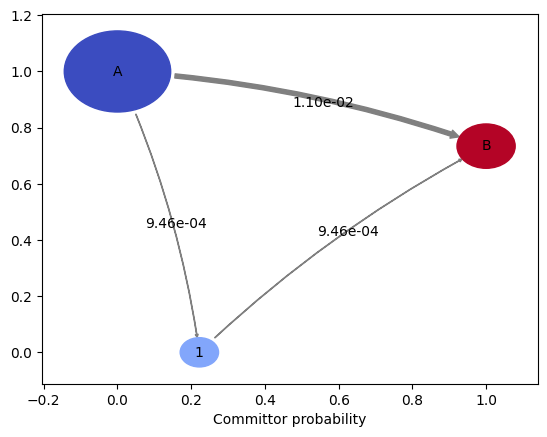

In [181]:
deeptime.plots.plot_flux(cg_flux[-1])

(<Axes: xlabel='Committor probability'>,
 array([[0.7241031 , 0.33409202],
        [0.808454  , 0.        ],
        [0.        , 0.7196386 ],
        [1.        , 1.        ]], dtype=float32))

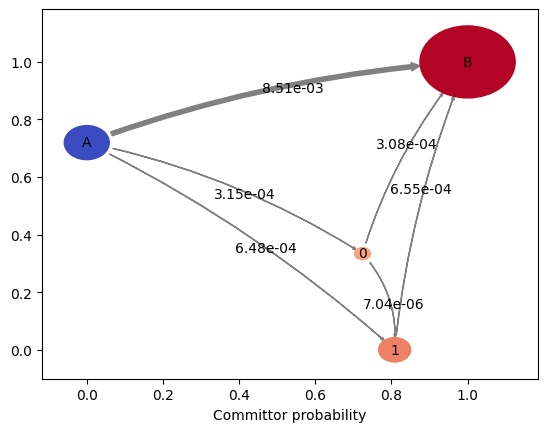

In [179]:
deeptime.plots.plot_flux(flux)

In [693]:
deeptime.plots.plot_flux(flux)

(<Axes: xlabel='Committor probability'>,
 array([[0.00000000e+00, 9.85854447e-01],
        [1.00000000e+00, 2.48757929e-01],
        [1.61917940e-01, 7.99296618e-01],
        [0.00000000e+00, 6.83409810e-01],
        [4.16011751e-01, 3.02137107e-01],
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 6.74768209e-01],
        [0.00000000e+00, 4.91935432e-01],
        [1.00000000e+00, 1.68866754e-01],
        [0.00000000e+00, 4.80587870e-01],
        [0.00000000e+00, 4.49112296e-01],
        [2.27323994e-01, 1.41332313e-01],
        [1.00000000e+00, 6.91785142e-02],
        [1.00000000e+00, 8.16304266e-01],
        [0.00000000e+00, 5.12516916e-01],
        [0.00000000e+00, 5.43882012e-01],
        [0.00000000e+00, 4.56470018e-03],
        [1.00000000e+00, 8.97661388e-01],
        [1.83559865e-01, 1.31466985e-01],
        [0.00000000e+00, 7.15821385e-01],
        [1.00000000e+00, 7.38410711e-01],
        [0.00000000e+00, 4.74091619e-01],
        [1.00000000e+00, 1.28296643

#### State 1 to state 2 is D2 to D1

In [188]:
# D1 --> D2
flux.rate, flux.mfpt

(0.015556614836726646, 64.2813369422223)

In [589]:
cg_flux[-1].rate, cg_flux[-1].mfpt

(0.015556614836726651, 64.28133694222227)

In [189]:
flux_r = final_msm.reactive_flux(np.where(a==stateB)[0], np.where(a==stateA)[0])

In [190]:
flux_r.rate

0.05224716175663545

In [191]:
flux_r.mfpt

19.139795663120378

In [192]:
# Kd = k_12 / k_21
flux.rate / flux_r.rate

0.29775042918481476

In [594]:
cg_pops = pcca.coarse_grained_stationary_probability
cg_pops

array([0.02095986, 0.08315948, 0.16361157, 0.73226909])

In [595]:
cg_flux[-1].stationary_distribution

array([0.6997569 , 0.09103058, 0.20921252])

In [596]:
# Kd = [D2] / [D1]
cg_pops[stateB] / cg_pops[stateA]

0.22343093870730507

In [597]:
# Kd = [D2] / [D1] from cg_flux
cg_flux[-1].stationary_distribution[-1] / cg_flux[-1].stationary_distribution[0]

0.29897886280971786

In [193]:
deeptime.plots.plot_flux(flux_r)

(<Axes: xlabel='Committor probability'>,
 array([[1.00000000e+00, 3.59733790e-01],
        [0.00000000e+00, 3.36289525e-01],
        [8.38082075e-01, 9.14064765e-01],
        [1.00000000e+00, 8.39628041e-01],
        [5.83988249e-01, 8.93070877e-01],
        [1.00000000e+00, 8.91834259e-01],
        [1.00000000e+00, 7.99813867e-01],
        [1.00000000e+00, 4.66447473e-01],
        [0.00000000e+00, 5.59617281e-01],
        [1.00000000e+00, 2.64718551e-02],
        [1.00000000e+00, 2.98876059e-03],
        [7.72675991e-01, 6.91663802e-01],
        [0.00000000e+00, 8.06226671e-01],
        [0.00000000e+00, 3.58919829e-01],
        [1.00000000e+00, 3.13098162e-01],
        [1.00000000e+00, 3.03346634e-01],
        [1.00000000e+00, 5.88494718e-01],
        [0.00000000e+00, 3.33983898e-01],
        [8.16440105e-01, 9.16817844e-01],
        [1.00000000e+00, 2.22493663e-01],
        [0.00000000e+00, 4.92517054e-01],
        [1.00000000e+00, 7.49678850e-01],
        [0.00000000e+00, 2.60451376

In [598]:
deeptime.plots.plot_flux(flux_r.coarse_grain((np.where(a==stateB)[0], np.where(a==stateA)[0]))[-1])

(<Axes: xlabel='Committor probability'>,
 array([[0.        , 0.68950254],
        [0.7778407 , 0.        ],
        [1.        , 1.        ]], dtype=float32))

What is the identity of each of these states?

In [320]:
cg_flux[-1].forward_committor

array([0.        , 0.50871222, 1.        ])

In [321]:
cg_flux[-1].backward_committor

array([1.        , 0.49128778, 0.        ])

In [329]:
# these are the state assignments
cg_flux[0]

[{0,
  3,
  4,
  7,
  10,
  12,
  13,
  14,
  15,
  19,
  20,
  22,
  24,
  26,
  28,
  30,
  31,
  32,
  35,
  36,
  37,
  38,
  40,
  41,
  46,
  47,
  52,
  56,
  60,
  61,
  62,
  63,
  65,
  66,
  70,
  71,
  75,
  76,
  77,
  79,
  82,
  84,
  86,
  87,
  88,
  94,
  95,
  98,
  99,
  102,
  103,
  106,
  107,
  108,
  111,
  112,
  114,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  126,
  127,
  128,
  129,
  130,
  131,
  134,
  136,
  137,
  139,
  140,
  141,
  144,
  145,
  150,
  152,
  153,
  155,
  156,
  157,
  160,
  161,
  163,
  164,
  167,
  170,
  173,
  174,
  177,
  182,
  183,
  185,
  186,
  188,
  190,
  192,
  196,
  197,
  198,
  199,
  200,
  201,
  202,
  203,
  206,
  208,
  209,
  210,
  211,
  218,
  221,
  225,
  226,
  227,
  228,
  229,
  230,
  232,
  235,
  236,
  238,
  239,
  240,
  242,
  243,
  247,
  248,
  252,
  253,
  255,
  257,
  258,
  259,
  260,
  261,
  262,
  265,
  266,
  269,
  270,
  271,
  274,
  275,
  276,
  277,
  2

In [345]:
np.array(list(cg_flux[0][1]))

array([  2,   5,   6,  16,  18,  23,  27,  29,  33,  34,  42,  43,  44,
        48,  50,  51,  53,  57,  58,  59,  64,  67,  78,  81,  90,  92,
        93,  96, 101, 104, 105, 110, 115, 124, 125, 133, 135, 146, 147,
       148, 149, 154, 158, 165, 171, 172, 175, 176, 178, 181, 184, 187,
       189, 191, 194, 195, 204, 207, 216, 217, 219, 220, 222, 223, 224,
       231, 234, 241, 244, 245, 251, 254, 256, 267, 272, 273, 278, 279,
       280, 286, 291, 294, 296, 297, 302, 306, 307, 314, 316, 351, 369,
       371, 373, 374, 376, 377, 381, 383, 384, 388, 391, 396, 411, 414,
       419, 423, 424, 425, 428, 431, 433, 434, 439, 444, 447])

In [348]:
final_dtrajs.shape

(5236748,)

In [352]:
pcca.memberships.shape

(450, 6)

In [349]:
# TODO: make cg_flux assignments into state labels, then use state labels to plot each microstate cluster cg assignment


IndexError: index 242 is out of bounds for axis 0 with size 242

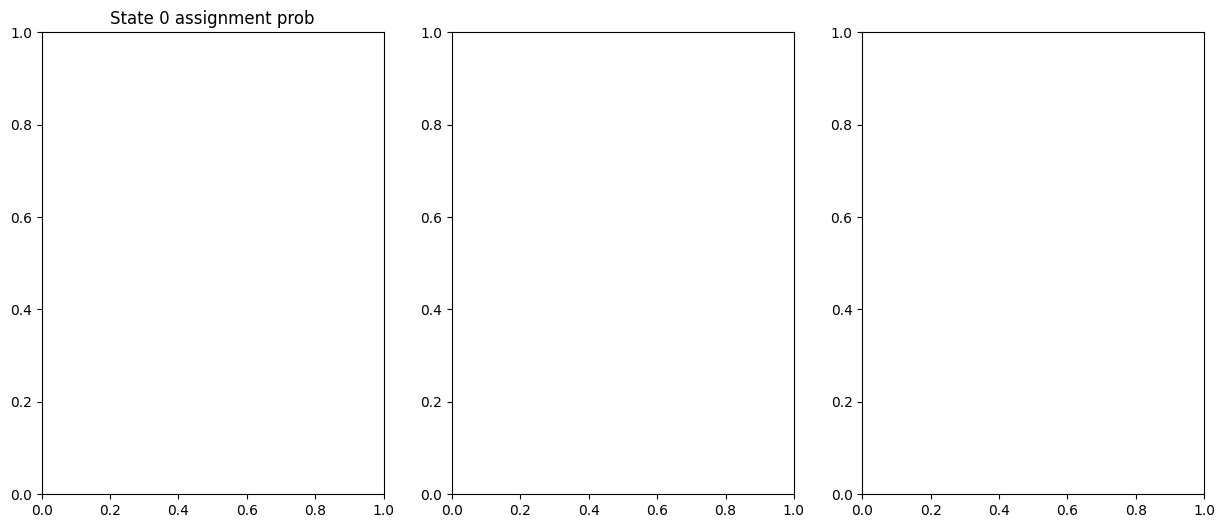

In [346]:
fig, axes = plt.subplots(1, len(cg_flux[0]), figsize=(15, 6))

for i in range(len(axes)):
    ax = axes[i]
    #ax.set_title(f"Metastable set {i+1} assignment prob")
    ax.set_title(f"State {i} assignment prob")

    #ax.scatter(*data.T, c=pcca.memberships[assignments, i], cmap=plt.cm.Blues)
    #ax.hexbin(*features[:,:2].T, C=pcca.memberships[final_dtrajs, i], cmap=plt.cm.Blues)
    #ax.hexbin(*features[:,-2:].T, C=pcca.memberships[final_dtrajs, i], cmap=plt.cm.Blues)
    #ax.hexbin(features[:,2], features[:,-1], C=pcca.memberships[final_dtrajs, i], cmap=plt.cm.Blues)
    #ax.hexbin(f1, f2, C=cg_flux[0][final_dtrajs, i], cmap=plt.cm.Blues)
    ax.hexbin(features[:,0], features[:,1], C=np.array(list(cg_flux[0][i])), cmap=plt.cm.Blues)
norm = mpl.colors.Normalize(vmin=0, vmax=1)
fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.Blues), ax=axes, shrink=.8);

Decompose flux into pathways? Only one intermediate state so...

In [ ]:
cg_flux[-1].pathways

## Checkpoint 4

In [30]:
np.save(f'{model_name}_final_tmatrix_450clusters.npy', final_msm.transition_matrix)

In [7]:
# Finding the index of frames closest to center
from scipy.cluster.vq import vq
cl, _ = vq(final_cluster.cluster_centers, dihedral_concat[::50])

np.save(f'{model_name}_closest_index.npy', cl)

In [ ]:
# Loading in the coordinates
folders = [f'{num+1:02d}' for num in range(10)]
data = []
for folder in tqdm(folders):
    data.append(np.load(f'{folder}/coords.npy'))[::10]
data_concat2 = np.concatenate(data)[::50]

In [ ]:
dihedral_concat2 = np.concatenate(dihedral)[::50]

In [ ]:
coords = {}
for idx, j in enumerate(tqdm(cl)):
    coords[idx] = data_concat2[j]
    
with open('coord_backmap.pickle', 'wb') as f:
    pickle.dump(coords, f)

In [8]:
pcoords = {}
for idx, j in enumerate(tqdm(cl)):
    pcoords[idx] = dihedral_concat2[j]
    
import pickle
with open('pcoord_backmap.pickle', 'wb') as f:
    pickle.dump(pcoords, f)

  0%|          | 0/200 [00:00<?, ?it/s]

## Figuring out the start/end states.

In [8]:
from scipy.cluster.vq import vq
cl, _ = vq( [[-82.9094, 46.4386]], final_cluster.cluster_centers,)
cl

array([108], dtype=int32)

In [9]:
final_cluster.cluster_centers[108]

array([-86.38787085,  43.94791794])

In [11]:
for idx, cluster in enumerate(final_cluster.cluster_centers):
    if -180 < cluster[1] <-125 and 25<cluster[0] <90:
        print(cluster)
        print(idx)

[  56.9945094  -164.70361737]
119


In [17]:
final_msm.transition_matrix[108,119]

5.397887155924061e-06